In [ ]:
#importing the necessary libraries

import tensorflow as tf
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from pprint import pprint
from keras.models import Sequential
from keras import models, layers
from keras.layers import Input, Reshape, Dot
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Concatenate, Dense, Dropout
from keras.layers import Add, Activation, Lambda
from keras.losses import mean_squared_error



In [ ]:
#connecting to Goole Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#unzipping the dataset
! unzip '/content/gdrive/MyDrive/ml-100k.zip'

Archive:  /content/gdrive/MyDrive/ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [ ]:
#finding the total users
stats_of_dataset = pd.read_csv('/content/ml-100k/u.info')
print("Total users involved in the loaded movielens dataset: ",list(stats_of_dataset))

#User rating data

column_names_user_ratings = ['user id','movie id','rating','timestamp']
user_ratings_data = pd.read_csv('ml-100k/u.data', sep='\t',names=column_names_user_ratings)
user_ratings_data.head() 

Total users involved in the loaded movielens dataset:  ['943 users']


,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
#movie details data

movie_column =  'movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
column_names_movie_details = movie_column.split(' | ')

movie_details_data = pd.read_csv('ml-100k/u.item', sep='|',header=None,names=column_names_movie_details,encoding='latin-1')

movie_details_data = movie_details_data[['movie id', 'movie title']]
movie_details_data.head()

,movie id,movie title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [ ]:
#Combining both the data for our final dataset
ratings_dataset = pd.merge(user_ratings_data, movie_details_data, how='inner', on='movie id')
final_dataset = ratings_dataset.groupby(by=['user id','movie title'], as_index=False).agg({"rating":"mean"})

final_dataset.head()



,user id,movie title,rating
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


In [ ]:
#encoding the users and movies

encode_u = LabelEncoder()
final_dataset['user'] = encode_u.fit_transform(final_dataset['user id'].values)
user_count = final_dataset['user'].nunique()
encode_m = LabelEncoder()
final_dataset['movie'] = encode_m.fit_transform(final_dataset['movie title'].values)
movie_count = final_dataset['movie'].nunique()
final_dataset['rating'] = final_dataset['rating'].values.astype(np.float32)
movie_rate_minimum = min(final_dataset['rating'])
movie_rate_maximum = max(final_dataset['rating'])
user_count, movie_count, movie_rate_minimum, movie_rate_maximum

final_dataset.head()

,user id,movie title,rating,user,movie
0,1,101 Dalmatians (1996),2.0,0,2
1,1,12 Angry Men (1957),5.0,0,3
2,1,"20,000 Leagues Under the Sea (1954)",3.0,0,6
3,1,2001: A Space Odyssey (1968),4.0,0,7
4,1,"Abyss, The (1989)",3.0,0,16


In [ ]:
#Splitting the dataset into training and test
user_movie = final_dataset[['user', 'movie']].values
rating = final_dataset['rating'].values
user_movie_train, user_movie_test, rating_train, rating_test = train_test_split(user_movie, rating, test_size=0.1, random_state=50)


user_movie_train_array = [user_movie_train[:, 0], user_movie_train[:, 1]]
user_movie_test_array = [user_movie_test[:, 0], user_movie_test[:, 1]]

#Normalizing the rating
rating_train = (rating_train - movie_rate_minimum)/(movie_rate_maximum - movie_rate_minimum)
rating_test = (rating_test - movie_rate_minimum)/(movie_rate_maximum - movie_rate_minimum)

In [ ]:
#building th model

#input layers
input_user = tf.keras.layers.Input(shape = (1,))
input_movie = tf.keras.layers.Input(shape = (1,))

embed_input = 100
#embedding layer for user and movie

layer_user = keras.layers.Embedding(user_count, embed_input, embeddings_regularizer= tf.keras.regularizers.l2(0.0001))(input_user)
layer_user = tf.keras.layers.Reshape((embed_input,))(layer_user)
layer_movie = keras.layers.Embedding(movie_count, embed_input,embeddings_regularizer= tf.keras.regularizers.l2(0.0001))(input_movie)
layer_movie = tf.keras.layers.Reshape((embed_input,))(layer_movie)

#adding the embedding layers
output_rating = tf.keras.layers.Concatenate()([layer_user,layer_movie])
output_rating = tf.keras.layers.Dropout(0.05)(output_rating)

#hidden layers
output_rating = tf.keras.layers.Dense(256)(output_rating)
output_rating = tf.keras.layers.Activation(activation='relu')(output_rating)
output_rating = tf.keras.layers.Dropout(0.05)(output_rating)

output_rating = tf.keras.layers.Dense(512)(output_rating)
output_rating = tf.keras.layers.Activation(activation='relu')(output_rating)
output_rating = tf.keras.layers.Dropout(0.05)(output_rating)

output_rating = tf.keras.layers.Dense(1024)(output_rating)
output_rating = tf.keras.layers.Activation(activation='relu')(output_rating)
output_rating = tf.keras.layers.Dropout(0.05)(output_rating)

#regularization layer
output_rating = tf.keras.layers.Dense(256)(output_rating)
output_rating = tf.keras.layers.Activation(activation='relu',activity_regularizer = l2(0.001))(output_rating)
output_rating = tf.keras.layers.Dropout(0.05)(output_rating)

#output layer
output_rating = tf.keras.layers.Dense(9)(output_rating)
output_rating = tf.keras.layers.Activation(activation='softmax')(output_rating)


predict_movies_model = tf.keras.models.Model(inputs=[input_user,input_movie], outputs=output_rating)
predict_movies_model.compile(optimizer='sgd', loss=mean_squared_error, metrics=['accuracy'])

#training the model
result = predict_movies_model.fit(x = user_movie_train_array, y = rating_train, batch_size=64, epochs=100, verbose=1, validation_data=(user_movie_test_array, rating_test)
,shuffle=True)

Epoch 1/100
1402/1402 [==============================] - 34s 24ms/step - loss: 0.3729 - accuracy: 0.0474 - val_loss: 0.3701 - val_accuracy: 0.0521
Epoch 2/100
1402/1402 [==============================] - 32s 23ms/step - loss: 0.3728 - accuracy: 0.0456 - val_loss: 0.3700 - val_accuracy: 0.0496
Epoch 3/100
1402/1402 [==============================] - 34s 24ms/step - loss: 0.3727 - accuracy: 0.0449 - val_loss: 0.3699 - val_accuracy: 0.0474
Epoch 4/100
1402/1402 [==============================] - 33s 23ms/step - loss: 0.3726 - accuracy: 0.0432 - val_loss: 0.3698 - val_accuracy: 0.0451
Epoch 5/100
1402/1402 [==============================] - 32s 23ms/step - loss: 0.3724 - accuracy: 0.0414 - val_loss: 0.3697 - val_accuracy: 0.0442
Epoch 6/100
1402/1402 [==============================] - 33s 24ms/step - loss: 0.3723 - accuracy: 0.0400 - val_loss: 0.3695 - val_accuracy: 0.0413
Epoch 7/100
1402/1402 [==============================] - 31s 22ms/step - loss: 0.3722 - accuracy: 0.0388 - val_loss: 0

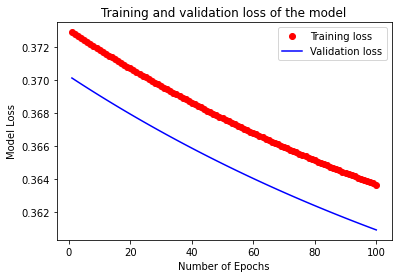

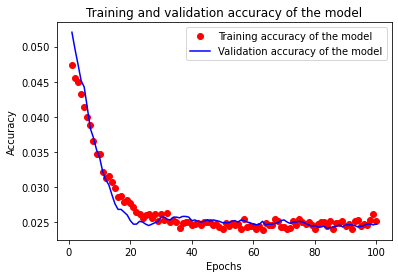

In [ ]:
#Graphs for Loss and Accuracy of the Model

training_loss = result.history['loss']
validation_loss = result.history['val_loss']
noofepochs = range(1,len(training_loss)+1)
plt.plot(noofepochs,training_loss,'ro',label='Training loss') 
plt.plot(noofepochs,validation_loss,'b',label='Validation loss')
plt.title("Training and validation loss of the model")
plt.xlabel('Number of Epochs')
plt.ylabel('Model Loss')
plt.legend()
plt.show()


plt.clf()
acc_values = result.history['accuracy']
val_acc_values = result.history['val_accuracy']
plt.plot(noofepochs,acc_values,'ro',label='Training accuracy of the model')
plt.plot(noofepochs,val_acc_values,'b',label='Validation accuracy of the model')
plt.title('Training and validation accuracy of the model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
input_id = [1]
encoded_input_id = encode_u.transform(input_id)

movies_seen_user = list(final_dataset[final_dataset['user id'] == input_id[0]]['movie'])
#print(movies_seen_user)

#picking  the id of unseen movies

len(final_dataset['movie'].unique()), min(final_dataset['movie']), max(final_dataset['movie'])
movies_unseen_user = [i for i in range(min(final_dataset['movie']), max(final_dataset['movie'])+1) if i not in movies_seen_user]
print(movies_unseen_user)

#check if the total of seen and unseen is equal to our total number of movies
#len(movies_unseen_user) + len(movies_seen_user)

[0, 1, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 37, 38, 39, 40, 42, 43, 45, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 85, 86, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 110, 111, 112, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 132, 135, 136, 137, 138, 139, 140, 141, 142, 144, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 176, 177, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 224, 227, 228, 231, 233, 234, 235, 236, 237, 239, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 256, 257, 258, 259, 260, 261, 2

In [ ]:
#testing of the model
predict_rating_model = [np.asarray(list(encoded_input_id)*len(movies_unseen_user)), np.asarray(movies_unseen_user)]
len(predict_rating_model), len(predict_rating_model[0])

final_ratings_unseen = predict_movies_model.predict(predict_rating_model)

#print(final_ratings_unseen)

final_ratings_unseen = np.max(final_ratings_unseen, axis=1)
#final_ratings_unseen

movie_rating = np.argsort(final_ratings_unseen)
#print(movie_rating)

movie_list = encode_m.inverse_transform(movie_rating)
#movie_list


pprint(list(movie_list[:20]))

44/44 [==============================] - 0s 6ms/step
['American Dream (1990)',
 "Pyromaniac's Love Story, A (1995)",
 'Frisk (1995)',
 'Indiana Jones and the Last Crusade (1989)',
 'Major Payne (1994)',
 'Shiloh (1997)',
 'Primal Fear (1996)',
 'Mark of Zorro, The (1940)',
 'Good Man in Africa, A (1994)',
 'Inventing the Abbotts (1997)',
 "It's My Party (1995)",
 'Beans of Egypt, Maine, The (1994)',
 'Dumbo (1941)',
 'Lone Star (1996)',
 'Once Upon a Time in America (1984)',
 'Basquiat (1996)',
 'FairyTale: A True Story (1997)',
 'Gold Diggers: The Secret of Bear Mountain (1995)',
 'Full Metal Jacket (1987)',
 'Grumpier Old Men (1995)']


In [ ]:
#building the final recommendation system 

def movie_recommend(user, model, movie):

  print("---------------------------------------------------------------------------------")
  print("Movie seen by the User:")
  pprint(list(final_dataset[final_dataset['user id'] == user]['movie title']))
  print("")

  encoded_input_id = encode_u.transform([user])

  movies_seen_user = list(final_dataset[final_dataset['user id'] == user]['movie'])
  movies_unseen_user = [m for m in range(min(final_dataset['movie']), max(final_dataset['movie'])+1) if m not in movies_seen_user]

  predict_rating_model = [np.asarray(list(encoded_input_id)*len(movies_unseen_user)), np.asarray(movies_unseen_user)]

  final_ratings_unseen = model.predict(predict_rating_model)
  final_ratings_unseen = np.max(final_ratings_unseen, axis=1)

  movie_rating = np.argsort(final_ratings_unseen)[::-1]
  movie_list = encode_m.inverse_transform(movie_rating)

  print("---------------------------------------------------------------------------------")
  print("Top "+str(movie)+" Movie recommendations for the User "+str(user)+ " are:")
  pprint(list(movie_list[:movie]))


print("---------------------------------------------------------------------------------")
print("Movie Recommendation System")
print("---------------------------------------------------------------------------------")
print("    ")
print("Enter user id")
user= int(input())

print("Enter number of movies to be recommended:")

movie = int(input())

movie_recommend(user, predict_movies_model, movie)

---------------------------------------------------------------------------------
Movie Recommendation System
---------------------------------------------------------------------------------
    
Enter user id
101
Enter number of movies to be recommended:
10
---------------------------------------------------------------------------------
Movie seen by the User:
['101 Dalmatians (1996)',
 'Associate, The (1996)',
 'Bed of Roses (1996)',
 'Black Sheep (1996)',
 'Broken Arrow (1996)',
 'Cable Guy, The (1996)',
 'Courage Under Fire (1996)',
 'Craft, The (1996)',
 'Down Periscope (1996)',
 'Dragonheart (1996)',
 'Eddie (1996)',
 'Eraser (1996)',
 'Escape from L.A. (1996)',
 'Fan, The (1996)',
 'Father of the Bride Part II (1995)',
 'Fear (1996)',
 'Feeling Minnesota (1996)',
 'Fled (1996)',
 'Fly Away Home (1996)',
 'Frighteners, The (1996)',
 'Glimmer Man, The (1996)',
 'Grumpier Old Men (1995)',
 'Happy Gilmore (1996)',
 'Hunchback of Notre Dame, The (1996)',
 'Independence Day (ID4) (1

In [ ]:
predict_movies_model.save('/content/gdrive/MyDrive/Movie recommendation')